# Building a simple NN classifier from scratch - PyTorch version
## 0.1 Environment set up
1. [Anaconda](https://www.anaconda.com/) or [miniconda](https://docs.conda.io/en/latest/miniconda.html) (a small, bootstrap version of Anaconda)

2. install jupyter notebook with python3 (base environment)
`conda install -c conda-forge notebook`
`conda install -c conda-forge nb_conda_kernels`

    install jupyter lab
`conda install -c conda-forge jupyterlab
conda install -c conda-forge nb_conda_kernels`

    install jupyter notebook extensions
`conda install -c conda-forge jupyter_contrib_nbextensions`


3. create new conda environment `conda create --name pytorch`


4. install [PyTorch](https://pytorch.org/get-started/locally/) `conda install pytorch torchvision torchaudio -c pytorch` 


5. install jupyter notebook in new environment
`conda install ipykernel`


6. install matplotlib
`pip install matplotlib`

## 0.2 Basic PyTorch
Ref:
- [PyTorch doc](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)
- [autograd package](https://pytorch.org/docs/stable/autograd.html)

In [ ]:
import torch

In [2]:
# play with torch data structure, same as numpy but with GPU acceleration
x = torch.rand(5, 3)
print(x)

tensor([[3.2374e-01, 7.4124e-01, 4.5525e-01],
        [7.5486e-01, 1.1378e-01, 5.4302e-01],
        [5.3822e-01, 5.6724e-01, 2.8513e-01],
        [3.4849e-01, 2.7817e-04, 9.1305e-01],
        [4.2904e-01, 8.1455e-03, 6.0758e-01]])


In [8]:
x = torch.rand(5,3)
print(x)

tensor([[0.3257, 0.9649, 0.8241],
        [0.5690, 0.7317, 0.0626],
        [0.7246, 0.9066, 0.9833],
        [0.5350, 0.7006, 0.7829],
        [0.1537, 0.3673, 0.5083]])


In [10]:
x = torch.zeros(5,3,dtype=torch.long)
x

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

## autograd - Automatic differentiation package

In [12]:
x = torch.ones(2, 2, requires_grad=True) #track the computation history
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [13]:
y = x+2
y

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

In [20]:
z = (y*y*3)
out = z.mean()
z,out

(tensor([[27., 27.],
         [27., 27.]], grad_fn=<MulBackward0>),
 tensor(27., grad_fn=<MeanBackward0>))

In [18]:
out.backward() 

In [19]:
x.grad

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])

suppose out as $o$, then $o = \frac{1}{4} \sum_i z_i$
$z_i = 3(x_i+2)^2$ and $z_i \bigr \rvert_{x_i=1} = 27$
    
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2),
\frac{\partial o}{\partial x_i}\bigr \rvert_{x_i=1} = \frac{9}{2} = 4.5$

## 1 Neural Networks (NN)

### A standard training process for NN
1. Set a NN model with learnable parameters (weight) 
2. Iterate on dataset
3. Process inputs on NN
4. Calculate loss
5. Backpropagate weights based on gradient 
6. Update weight based on weight = weight - learning_rate * gradient

In [39]:
import torch.nn as nn
import torch.nn.functional as F

# set up a NN
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input image channel, 6 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [28]:
params = list(net.parameters()) # since the output size of our last fully connected layer is 10
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


Test a random input with size 32x32

In [24]:
input = torch.randn(1, 1, 32, 32)

tensor([[ 0.0605,  0.0536, -0.0716, -0.0461,  0.1117, -0.0940, -0.0305,  0.0092,
         -0.0442, -0.0187]], grad_fn=<AddmmBackward0>)


In [31]:
#loss function
output = net(input)
target = torch.randn(10)  
target = target.view(1, -1)  #set target as the same shape as the output 
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.2678, grad_fn=<MseLossBackward0>)


### Backward

In [32]:
net.zero_grad()     # vanish grad

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0126, -0.0043,  0.0223, -0.0013, -0.0199, -0.0142])


In [33]:
# update weights
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

## 2 Simple NN classifier - CIFAR10

Right now we build a NN and can update weights using backpropagation, the next step is to create a classifier based on this NN. We will use CIFAR10 dataset as the input and the above NN to train the classifier.

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms

In [35]:
# load CIFAR10 dataset 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 frog  cat  dog bird


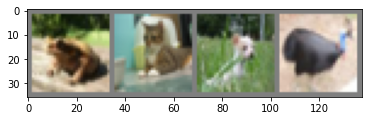

In [38]:
import matplotlib.pyplot as plt
import numpy as np

#visualize img
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('%5s' % classes[labels[j]] for j in range(4)))

### Define a loss and optimizer

In [40]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [47]:
for epoch in range(2):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.213
[1,  4000] loss: 1.210
[1,  6000] loss: 1.192
[1,  8000] loss: 1.184
[1, 10000] loss: 1.178
[1, 12000] loss: 1.180
[2,  2000] loss: 1.088
[2,  4000] loss: 1.100
[2,  6000] loss: 1.099
[2,  8000] loss: 1.150
[2, 10000] loss: 1.092
[2, 12000] loss: 1.089
Finished Training


In [ ]:
# save model 
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Test the network on the test data

GroundTruth:    cat  ship  ship plane


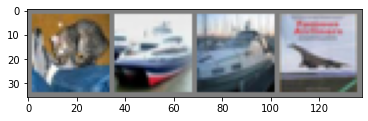

In [42]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [43]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


Look the network performances on the whole dataset

In [44]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [45]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 73 %
Accuracy of  bird : 41 %
Accuracy of   cat : 36 %
Accuracy of  deer : 43 %
Accuracy of   dog : 49 %
Accuracy of  frog : 62 %
Accuracy of horse : 70 %
Accuracy of  ship : 61 %
Accuracy of truck : 62 %


### Training with GPU

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

net.to(device)
inputs, labels = inputs.to(device), labels.to(device)

cpu
